In [27]:
#importing all the required libraries and modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)


In [28]:
# Loading the dataset

df = pd.read_csv("heart.csv")

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nHead:\n", df.head())
print("\nMissing values per column:\n", df.isna().sum())

Shape: (1025, 14)

Columns: ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholestoral', 'fasting_blood_sugar', 'rest_ecg', 'Max_heart_rate', 'exercise_induced_angina', 'oldpeak', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia', 'target']

Head:
    age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T 

In [29]:
#Basic cleaning of the dataset

has_missing = df.isna().any().any()
print("\nAny missing values in dataset?:", has_missing)

# Define target and features

TARGET_COL = 'target'
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]



Any missing values in dataset?: False



Basic Describe (numerics):
                age  resting_blood_pressure  cholestoral  Max_heart_rate  \
count  1025.000000             1025.000000   1025.00000     1025.000000   
mean     54.434146              131.611707    246.00000      149.114146   
std       9.072290               17.516718     51.59251       23.005724   
min      29.000000               94.000000    126.00000       71.000000   
25%      48.000000              120.000000    211.00000      132.000000   
50%      56.000000              130.000000    240.00000      152.000000   
75%      61.000000              140.000000    275.00000      166.000000   
max      77.000000              200.000000    564.00000      202.000000   

           oldpeak       target  
count  1025.000000  1025.000000  
mean      1.071512     0.513171  
std       1.175053     0.500070  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.800000     1.000000  
75%       1.800000     1.000000  
max       6.200000     

<Figure size 1200x800 with 0 Axes>

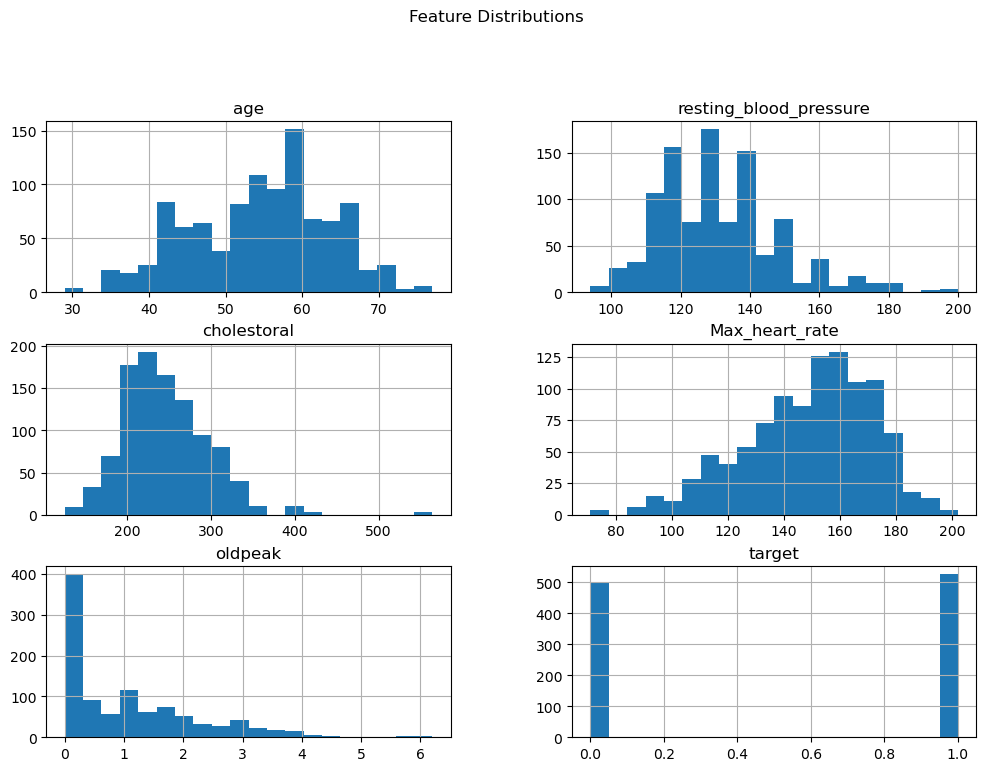

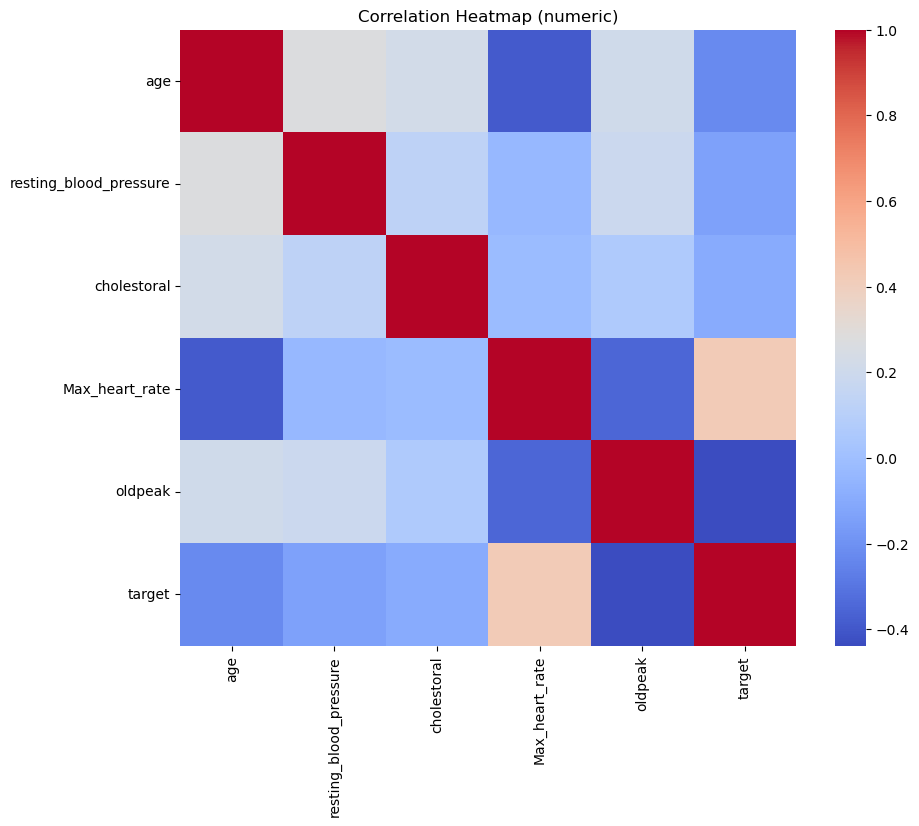

In [30]:
# Performing Exploratory Data Analysis (EDA)

print("\nBasic Describe (numerics):\n", df.describe())

# Histograms of numeric features
plt.figure(figsize=(12, 8))
df.hist(bins=20, figsize=(12, 8))
plt.suptitle("Feature Distributions", y=1.02)
plt.show()

# Correlation heatmap (numeric-only)
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm", square=True)
plt.title("Correlation Heatmap (numeric)")
plt.show()


In [31]:
# FEATURE TYPES & PREPROCESSING

numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
# Heuristic: columns with few unique values are likely categorical codes
maybe_cat = [c for c in numeric_cols if X[c].nunique() <= 10]
# Some sets treat these as categorical (common in this dataset):
likely_cat_names = set(['sex','cp','fbs','restecg','exang','slope','ca','thal'])
categorical_cols = sorted(list(set(maybe_cat).union(likely_cat_names).intersection(X.columns)))
# Numeric = numeric minus those chosen as categorical
numeric_cols = [c for c in numeric_cols if c not in categorical_cols]

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Preprocessors:
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())  # helps Logistic Regression
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_cols),
        ("cat", categorical_preprocess, categorical_cols)
    ],
    remainder="drop"
)


Numeric columns: ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']
Categorical columns: ['sex', 'slope']


In [32]:
# TRAIN/TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (820, 13), Test size: (205, 13)


In [33]:
# TRAINING MODEL (Logistic Regression)

logreg_pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=200, solver="lbfgs"))
])

logreg_pipeline.fit(X_train, y_train)



Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'resting_blood_pressure',
                                                   'cholestoral',
                                                   'Max_heart_rate',
                                                   'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'slope'])])),
                ('clf', LogisticRegression(max_iter=200))])


Accuracy - Logistic Regression: 0.790
ROC-AUC  - Logistic Regression: 0.869


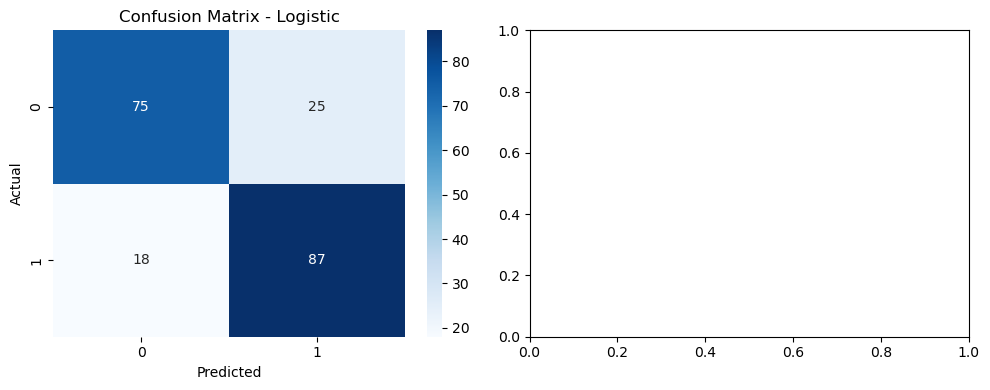

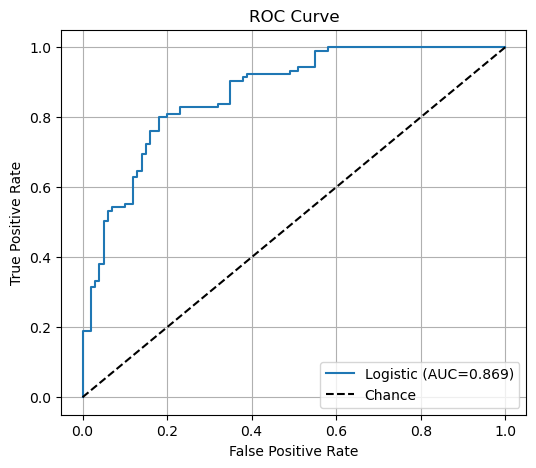


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0      0.806     0.750     0.777       100
           1      0.777     0.829     0.802       105

    accuracy                          0.790       205
   macro avg      0.792     0.789     0.790       205
weighted avg      0.791     0.790     0.790       205



In [34]:
# EVALUATION: Accuracy, ROC-AUC, Confusion Matrix

# Predictions
y_pred_log = logreg_pipeline.predict(X_test)

# Probabilities for ROC/AUC
y_proba_log = logreg_pipeline.predict_proba(X_test)[:, 1]

# Accuracy
acc_log = accuracy_score(y_test, y_pred_log)
print(f"\nAccuracy - Logistic Regression: {acc_log:.3f}")

# ROC-AUC
auc_log = roc_auc_score(y_test, y_proba_log)
print(f"ROC-AUC  - Logistic Regression: {auc_log:.3f}")

# Confusion matrices
cm_log = confusion_matrix(y_test, y_pred_log)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Logistic")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# ROC curves
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)

plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC={auc_log:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print("\nClassification Report - Logistic Regression:")
print(classification_report(y_test, y_pred_log, digits=3))


Top 10 influential features (Logistic Regression):
                  feature      coef
6                sex_Male -0.843623
5              sex_Female  0.836629
4                 oldpeak -0.692839
3          Max_heart_rate  0.657368
8              slope_Flat -0.584522
9         slope_Upsloping  0.331258
2             cholestoral -0.312961
1  resting_blood_pressure -0.299249
7       slope_Downsloping  0.246270
0                     age -0.178700

Top 10 important features (Decision Tree):
                  feature  importance
4                 oldpeak    0.392771
3          Max_heart_rate    0.219918
0                     age    0.214814
1  resting_blood_pressure    0.087109
7       slope_Downsloping    0.061957
6                sex_Male    0.023431
2             cholestoral    0.000000
5              sex_Female    0.000000
8              slope_Flat    0.000000
9         slope_Upsloping    0.000000


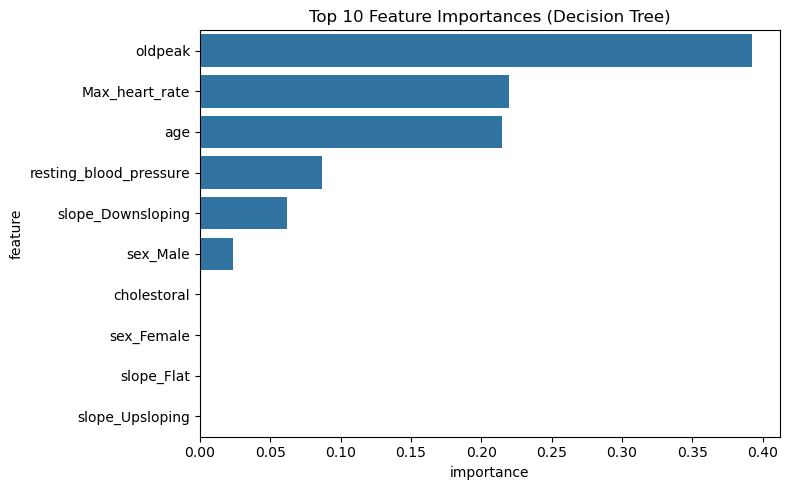

In [35]:
# FEATURE IMPORTANCE / INFLUENCE

# Helper to get feature names out of the ColumnTransformer
def get_feature_names_from_ct(ct):
    feature_names = []

    # Numeric pipeline -> same names
    num_features = ct.transformers_[0][2]
    # Categorical pipeline -> OneHotEncoder expands features
    cat_features = ct.transformers_[1][2]

    # numeric names (scaler doesn't change names)
    feature_names.extend(num_features)

    # categorical expanded names
    ohe = ct.transformers_[1][1].named_steps["onehot"]
    ohe_names = ohe.get_feature_names_out(cat_features)
    feature_names.extend(ohe_names.tolist())

    return feature_names

feature_names = get_feature_names_from_ct(preprocessor)

# --- Logistic Regression coefficients (after scaling & one-hot)
log_clf = logreg_pipeline.named_steps["clf"]
log_coefs = log_clf.coef_[0]  # shape: (n_features, )

# Sort by absolute value (strongest impact first)
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": log_coefs,
    "abs_coef": np.abs(log_coefs)
}).sort_values("abs_coef", ascending=False)

print("\nTop 10 influential features (Logistic Regression):")
print(coef_df.head(10)[["feature", "coef"]])

# --- Decision Tree feature importances
tree_clf = tree_pipeline.named_steps["clf"]
# ColumnTransformer changes the space, but pipeline handles it; importances align to transformed features
tree_importances = tree_clf.feature_importances_

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": tree_importances
}).sort_values("importance", ascending=False)

print("\nTop 10 important features (Decision Tree):")
print(imp_df.head(10))

# Optional: visualize top importances for tree
top_n = 10
plt.figure(figsize=(8, 5))
sns.barplot(
    data=imp_df.head(top_n),
    x="importance", y="feature"
)
plt.title(f"Top {top_n} Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()